This notebook shows how to apply **transformations** and **post-processing** functions to an **SDF** field and calculate the **gradient** of the **SDF** field with respect to the **parameters** of the **transformation**, or the **SDF** function.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from jax import jvp, jacfwd
import jax.numpy as jnp

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.jax_cores.sdf_2D_jax import sdf_circle

from spomso.jax_cores.transformations_jax import compound_euclidian_transform_sdf

from spomso.jax_cores.post_processing_jax import hard_binarization_jax
from spomso.jax_cores.post_processing_jax import relu_jax, linear_falloff_jax
from spomso.jax_cores.post_processing_jax import gaussian_boundary_jax, gaussian_falloff_jax
from spomso.jax_cores.post_processing_jax import capped_exponential_jax, sigmoid_falloff_jax

# PARAMETERS

In [2]:
# size of the volume
co_size = 4, 4
# resolution of the volume
co_resolution = 400, 400

show = "POSTPROCESSING"  # FIELD, POSTPROCESSING
show_midplane = True
show_3d = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the radius of a **circle**:

In [4]:
radius = 1.

Define the **position** of the **circle**:

In [5]:
x = 0.
y = 0.

Define a new **SDF** where the **position** and **radius** of the **circle** are the **parameters**:

In [6]:
def transformed_circle(x0, y0, r):
    vec = jnp.asarray([x0, y0, 0])
    return compound_euclidian_transform_sdf(sdf_circle, jnp.eye(3), vec, 1.)(coor, r)


## EVALUATE

Evaluate the **SDF** of the **geometry** to create a signed distance field 2D map.

In [7]:
final_pattern = transformed_circle(x, y, radius)

Calculate the **Jacobian** with respect to the **x-position** (argnums=0), **y-position** (argnums=1), or **radius** (argnums=2):

In [8]:
gradient_pattern = jacfwd(transformed_circle, argnums=0)(x, y, radius)

# POST-PROCESSING

Convert the final pattern and the gradient pattern into a 2D image:

In [9]:
field = smarter_reshape(final_pattern, co_resolution)
gradient_field = smarter_reshape(gradient_pattern, co_resolution)

The **SDF** field can be transformed into other scalar fields with various operations.
One of the possibilities is to apply a **post-processing** function on top of the **SDF** field.

Above we calculated the **Jacobian** of the **SDF** of a **circle**, now using the *jax.jvp* function we can apply the **post-processing** and calculate the **gradients** with respect to the **radius**.

In the *primals* argument we use parameters of the **post-processing** function and in the *tangents* arguments we use the **Jacobian** we calculated above, the *tangents* for the **post-processing** function **parameters** we set to **zero**, since we are not interested in the **JVP** with respect to the **post-processing function parameters**.

## CAPPED EXPONENTIAL

Set the **amplitude** of the **capped exponential** post-processing function to **1** and the **width** to **0.5**:

In [10]:
ce, grad_ce = jvp(capped_exponential_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
ce, grad_ce = smarter_reshape(ce, co_resolution), smarter_reshape(grad_ce, co_resolution)

## ReLU

Set the **width** parameters of the **ReLU** post-processing function to **1**:

In [11]:
rl, grad_rl = jvp(relu_jax, (final_pattern, 1.0), (gradient_pattern, 0.))
rl, grad_rl = smarter_reshape(rl, co_resolution), smarter_reshape(grad_rl, co_resolution)

## Gaussian Boundary

Set the **amplitude** of the **gaussian boundary** post-processing function to **1** and the **width** to **0.5**:

In [12]:
gb, grad_gb = jvp(gaussian_boundary_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
gb, grad_gb = smarter_reshape(gb, co_resolution), smarter_reshape(grad_gb, co_resolution)

## Linear Falloff

Set the **amplitude** of the **linear falloff** post-processing function to **1** and the **width** to **0.5**:

In [13]:
lf, grad_lf = jvp(linear_falloff_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
lf, grad_lf = smarter_reshape(lf, co_resolution), smarter_reshape(grad_lf, co_resolution)

## Sigmoid Falloff

Set the **amplitude** of the **sigmoid falloff** post-processing function to **1** and the **width** to **0.5**:

In [14]:
sf, grad_sf = jvp(sigmoid_falloff_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
sf, grad_sf = smarter_reshape(sf, co_resolution), smarter_reshape(grad_sf, co_resolution)

## Gaussian Falloff

Set the **amplitude** of the **gaussian falloff** post-processing function to **1** and the **width** to **0.5**:

In [15]:
gf, grad_gf = jvp(gaussian_falloff_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
gf, grad_gf = smarter_reshape(gf, co_resolution), smarter_reshape(grad_gf, co_resolution)

## Hard Binarization

Set the **threshold** parameter of the **hard binarization** post-processing function to **0**:

In [16]:
hb, grad_hb = jvp(hard_binarization_jax, (final_pattern, 0.0), (gradient_pattern, 0.))
hb, grad_hb = smarter_reshape(hb, co_resolution), smarter_reshape(grad_hb, co_resolution)
grad_hb = np.zeros(grad_hb.shape) if grad_hb.dtype is not gradient_field.dtype else grad_hb

# PLOT

In [17]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show == "FIELD":
    fig, axs = plt.subplots(1, 2, figsize=(2*8.25, 8.25))

    # FIELD
    axs[0].imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = axs[0].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    axs[0].clabel(cs1, inline=True, fontsize=10)
    axs[0].grid()

    # GRADIENT
    axs[1].imshow(gradient_field[:, :].T,
                  cmap="binary_r",
                  extent=(-co_size[0] / 2, co_size[0] / 2,
                          -co_size[1] / 2, co_size[1] / 2),
                  origin="lower"
                  )
    cs2 = axs[1].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                        coor[1].reshape(co_res_new[0], co_res_new[1]),
                        gradient_field[:, :],
                        cmap="plasma_r",
                        linewidths=2)
    axs[1].clabel(cs2, inline=True, fontsize=10)
    axs[1].grid()

    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        
    fig.tight_layout()
    plt.show()

Drawing results...


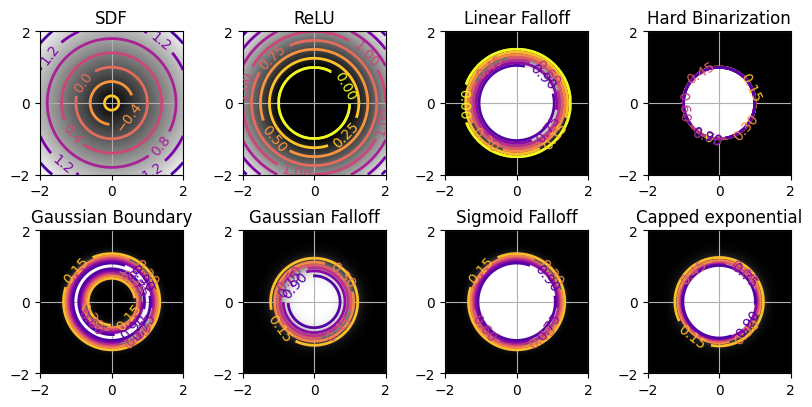

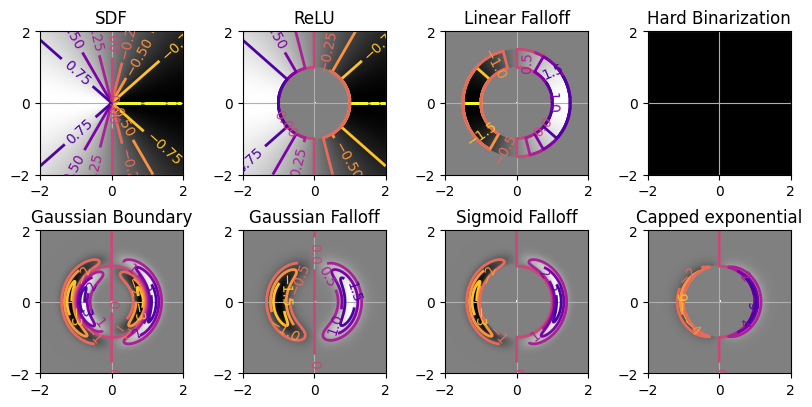

In [18]:
if show_midplane and show == "POSTPROCESSING":

    # FIELD
    fig, axs = plt.subplots(2, 4, figsize=(8.25, 8.25 / 2))

    patterns = ((field, rl, lf, hb), (gb, sf, gf, ce))
    titles = (("SDF", "ReLU", "Linear Falloff", "Hard Binarization"),
              ("Gaussian Boundary", "Gaussian Falloff", "Sigmoid Falloff", "Capped exponential",))
    for i in range(2):
        for j in range(4):
            ax = axs[i, j]
            ax.imshow(patterns[i][j][:, :].T,
                      cmap="binary_r",
                      extent=(-co_size[0] / 2, co_size[0] / 2,
                              -co_size[1] / 2, co_size[1] / 2),
                      origin="lower"
                      )
            cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                            coor[1].reshape(co_res_new[0], co_res_new[1]),
                            patterns[i][j][:, :],
                            cmap="plasma_r",
                            linewidths=2)
            ax.clabel(cs, inline=True, fontsize=10)
            ax.set_xticks(np.linspace(-co_size[0] / 2, co_size[0] / 2, 3))
            ax.set_yticks(np.linspace(-co_size[1] / 2, co_size[1] / 2, 3))
            ax.grid()
            ax.set_title(titles[i][j])

    fig.tight_layout()
    plt.show()

    # GRADIENT
    fig, axs = plt.subplots(2, 4, figsize=(8.25, 8.25 / 2))

    patterns = ((gradient_field, grad_rl, grad_lf, grad_hb), (grad_gb, grad_sf, grad_gf, grad_ce))
    titles = (("SDF", "ReLU", "Linear Falloff", "Hard Binarization"),
              ("Gaussian Boundary", "Gaussian Falloff", "Sigmoid Falloff", "Capped exponential",))
    for i in range(2):
        for j in range(4):
            ax = axs[i, j]
            ax.imshow(patterns[i][j][:, :].T,
                      cmap="binary_r",
                      extent=(-co_size[0] / 2, co_size[0] / 2,
                              -co_size[1] / 2, co_size[1] / 2),
                      origin="lower"
                      )
            cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                            coor[1].reshape(co_res_new[0], co_res_new[1]),
                            patterns[i][j][:, :],
                            cmap="plasma_r",
                            linewidths=2)
            ax.clabel(cs, inline=True, fontsize=10)
            ax.set_xticks(np.linspace(-co_size[0] / 2, co_size[0] / 2, 3))
            ax.set_yticks(np.linspace(-co_size[1] / 2, co_size[1] / 2, 3))
            ax.grid()
            ax.set_title(titles[i][j])

    fig.tight_layout()
    plt.show()

In [ ]:
if show_3d:
    # FIELD
    patterns = ((field, rl, lf, hb), (gb, sf, gf, ce))
    titles = ("SDF", "ReLU", "Linear Falloff", "Hard Binarization",
              "Gaussian Boundary", "Gaussian Falloff", "Sigmoid Falloff", "Capped exponential")

    fig = make_subplots(rows=2, cols=4,
                        specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
                               [{'is_3d': True}, {'is_3d': True}, {'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(2):
        for j in range(4):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True, "start": 0.0, "end": 1, "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1 + i, 1 + j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()

    # GRADIENT
    patterns = ((gradient_field, grad_rl, grad_lf, grad_hb), (grad_gb, grad_sf, grad_gf, grad_ce))
    titles = ("SDF", "ReLU", "Linear Falloff", "Hard Binarization",
              "Gaussian Boundary", "Gaussian Falloff", "Sigmoid Falloff", "Capped exponential")

    fig = make_subplots(rows=2, cols=4,
                        specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
                               [{'is_3d': True}, {'is_3d': True}, {'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(2):
        for j in range(4):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True,
                                               "start": np.floor(np.amin(patterns[i][j][:, :]*10))/10,
                                               "end": np.ceil(np.amax(patterns[i][j][:, :]*10))/10,
                                               "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1 + i, 1 + j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()
